### Notebook for the `NicheCompass` exploratory analysis of 10X Genomics Xenium for BRCA  

- **Developed by**: Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology (WüSI) & Julius-Maximilian-Universität Würzburg**
- **Created**: 230620
- **Last modified**: 230714

### Load required packages

In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
import squidpy as sq
import seaborn as sns
from pywaffle import Waffle
import matplotlib.pyplot as plt
import plotly.graph_objects as go

### Set up wortking environment 

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'magma', dpi_save = 300, vector_friendly = True, format = 'svg', fontsize = 8)

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                         10.0.0
appnope                     0.1.3
asciitree                   NA
asttokens                   NA
attr                        23.1.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
certifi                     2023.07.22
charset_normalizer          3.2.0
cloudpickle                 2.2.1
comm                        0.1.4
cycler                      0.10.0
cython_runtime              NA
dask                        2023.9.0
dask_image                  2023.08.1
datashader                  0.15.2
datashape                   0.5.2
datatree                    0.0.12
dateutil                    2.8.2
debugpy                     1.6.7.post1
decorator                   5.1.1
docrep                      0.3.2
entrypoints                 0.4
exceptiongroup              1.1.3
executing                   1.2.0
fasteners                   0.18
fsspec                      2

In [4]:
color_palette = sns.color_palette("Paired", 26)

### Read in Xenium dataset

In [6]:
adata = sc.read("../../datasets/xenium/xenium_human_breast_cancer_analysis.h5ad")
adata

AnnData object with n_obs × n_vars = 282363 × 313
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'replicates', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'leiden', 'cell_states', 'batch', 'mapping_entity', 'latent_leiden_0.2', 'LTA_ligand_receptor_GP', 'TNFSF13_ligand_receptor_target_gene_GP', 'TFF2_ligand_receptor_GP', 'L-Cysteine_metabolite_enzyme_sensor_GP', 'Hydrogen_sulfide_metabolite_enzyme_sensor_GP', 'IGSF21_ligand_receptor_target_gene_GP', 'Pyruvic_acid_metabolite_enzyme_sensor_GP', 'TIMP2_ligand_receptor_target_gene_GP', 'COL4A1_ligand_receptor_target_gene_GP', 'CD5L_ligand_receptor_target_gene_GP', 'WNT16_ligand_receptor_target_gene_GP', 'CORT_ligand_receptor_target_gene_GP', 'LGI3_ligand_re

### Rename cell types and niches

In [7]:
trans_from=[['Epi_ABCC11+', 'Epi_FOXA1+', 'Epi_AGR3+', 'Epi_CENPF+', 'mgEpi_KRT14+', 'Epi_KRT14+'],['EC_CLEC14A+', 'EC_CAVIN2+'],['adipo_FB', 'GJB2+iKC-FB'],['EMT-Epi1_CEACAM6+', 'EMT-Epi2_CEACAM6+', 'EMT-Epi_SERPINA3+', 'EMT-Epi_KRT23+'],['DERL3+B', 'BANK1+B', 'B'],['eff_CD8+T1', 'eff_CD8+T2',],['tcm_CD4+T', 'CD161+FOXP3+T'],['NK/T'],['ADIPOQ+Mast'],['M2MØ', 'MMP12+miMØ'], ['DC1']]
trans_to = ['Epithelial', 'Endothelial', 'Fibroblast', 'EMT-Epi', 'B_cells', 'CD8+T', 'CD4+T', 'NK/T', 'Mast', 'MØ', 'DC']

adata.obs['cell_type'] = [str(i) for i in adata.obs['cell_states']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        adata.obs['cell_type'][adata.obs['cell_type'] == leiden_from] = celltype

/var/folders/j1/l8rz6t7953z7vlpdytk0pbv40000gn/T/ipykernel_19138/186565815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_type'][adata.obs['cell_type'] == leiden_from] = celltype
/var/folders/j1/l8rz6t7953z7vlpdytk0pbv40000gn/T/ipykernel_19138/186565815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_type'][adata.obs['cell_type'] == leiden_from] = celltype
/var/folders/j1/l8rz6t7953z7vlpdytk0pbv40000gn/T/ipykernel_19138/186565815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

### Visualise cellular proportions per niche

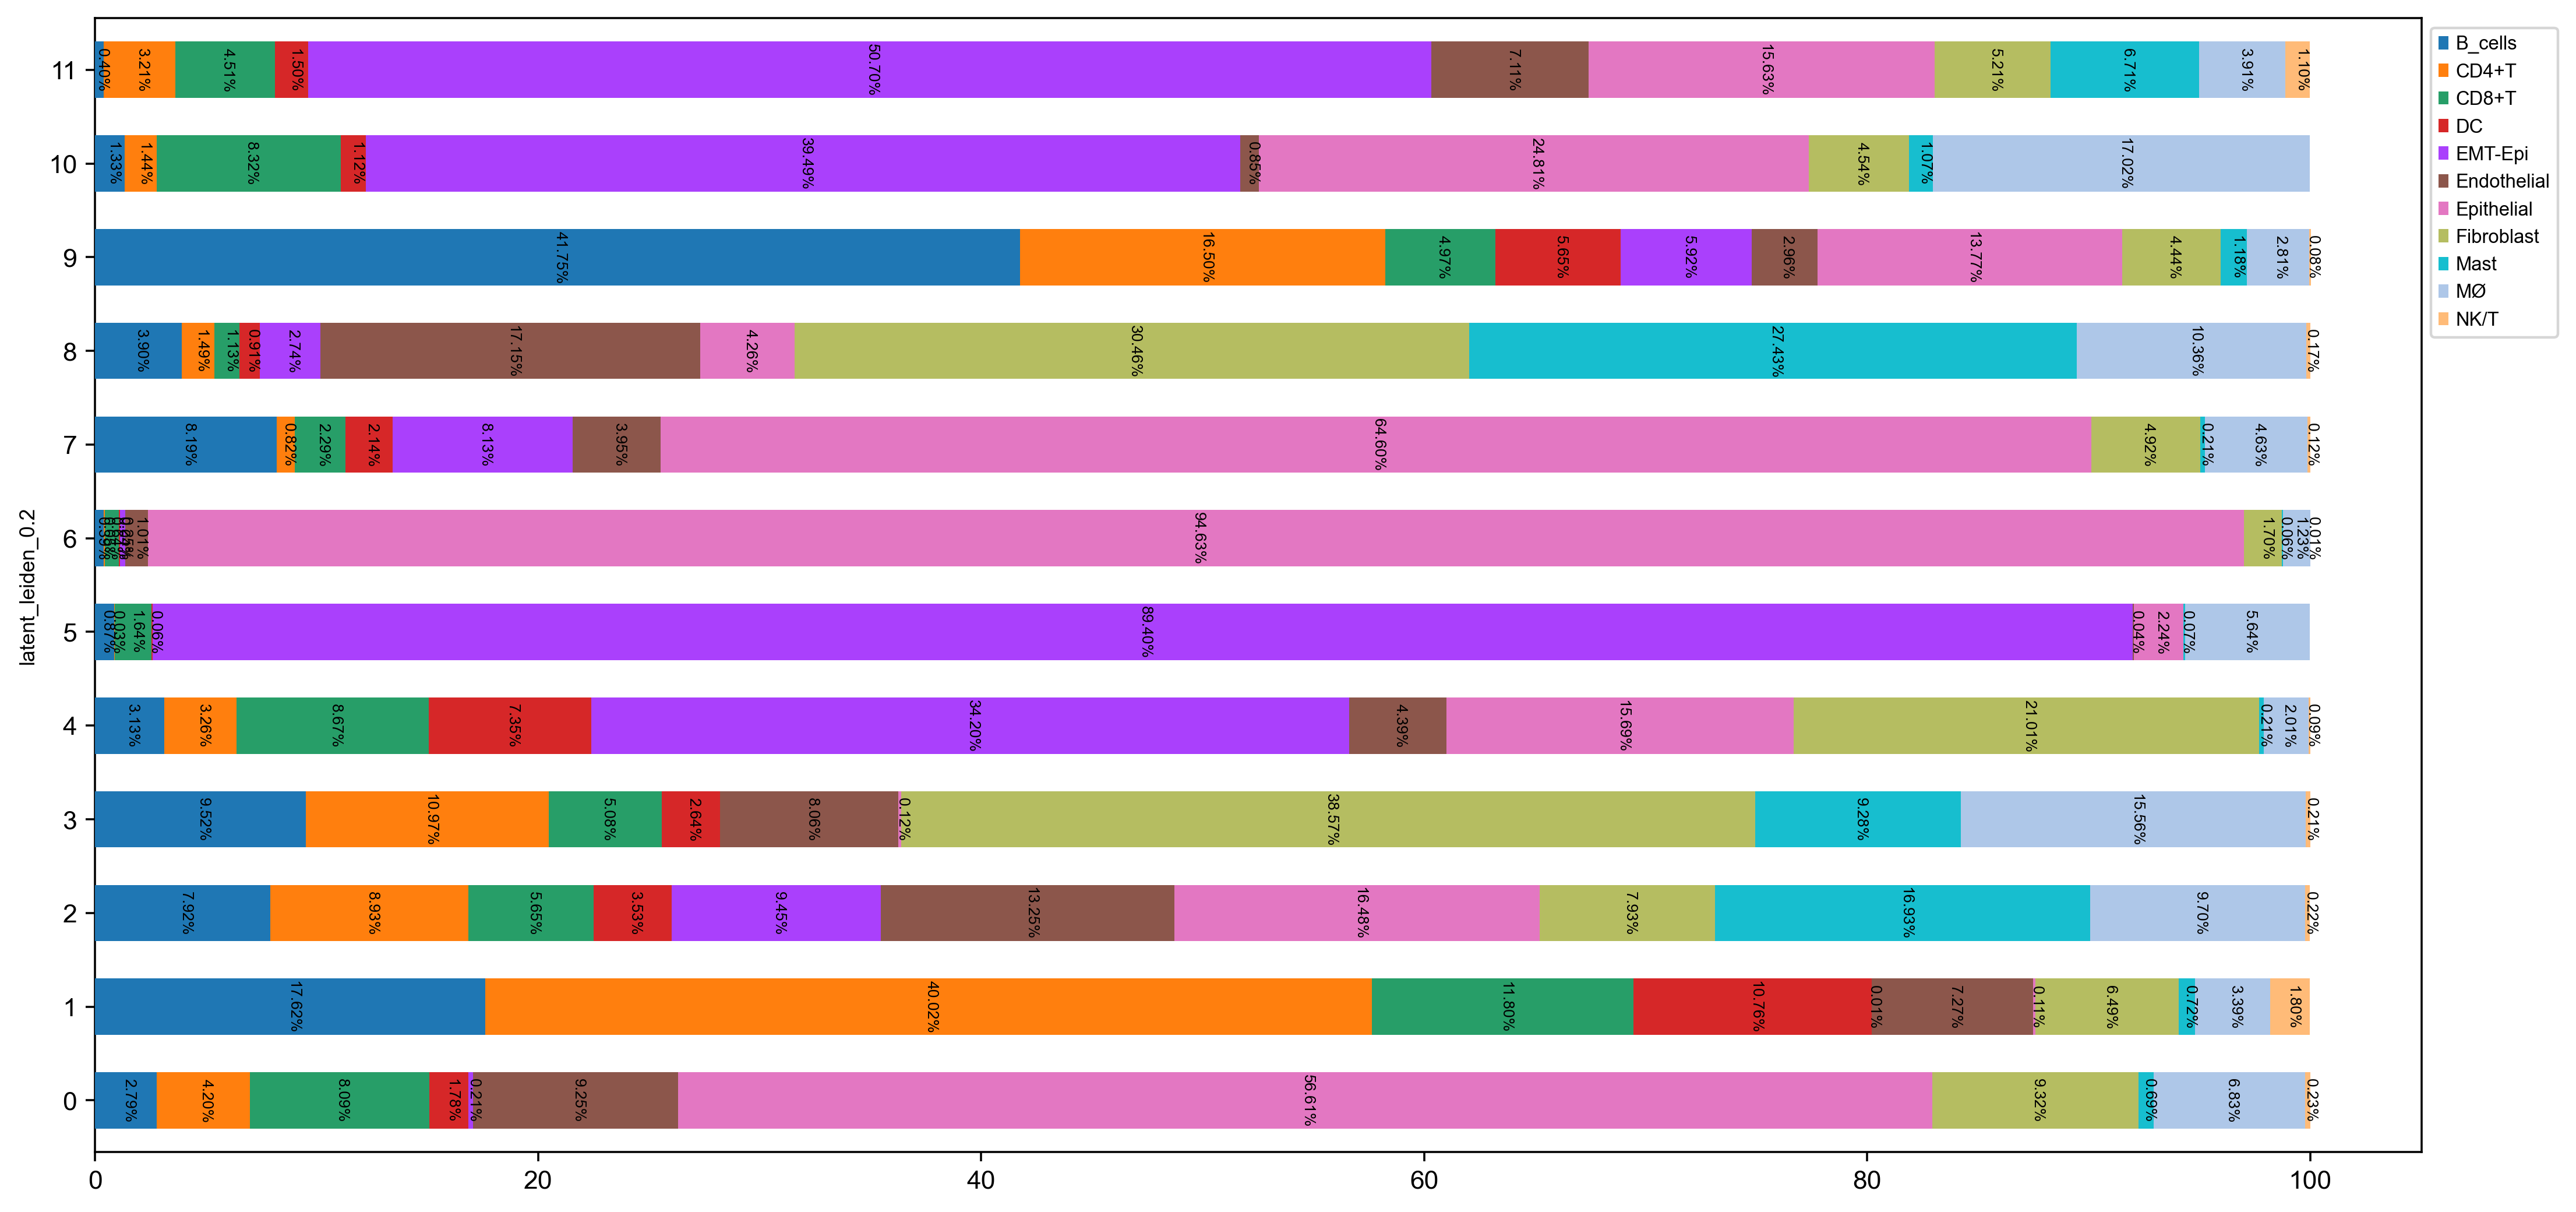

In [8]:
data = pd.crosstab(adata.obs['latent_leiden_0.2'], adata.obs['cell_type'])
totals = data.sum(axis = 1)
percent = data.div(totals, axis = 0).mul(100).round(2)

ax1 = percent.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (16,8), fontsize = 10, grid = False, width = 0.6)
horiz_offset = 1.0
vert_offset = 1.0
ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset), ncol = 1)

for c in ax1.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{w:0.2f}%' if (w := v.get_width()) > 0 else '' for v in c]
    
    # add annotations
    ax1.bar_label(c, labels = labels, label_type = 'center', padding = 1, color = 'black', rotation = 270, fontsize = 6)

In [10]:
adata.obs['niche'].value_counts()

niche
0     58568
1     55071
2     40559
3     24887
4     23199
5     23013
6     20951
7     20815
8      9791
9      2637
10     1874
11      998
Name: count, dtype: int64

/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_ma

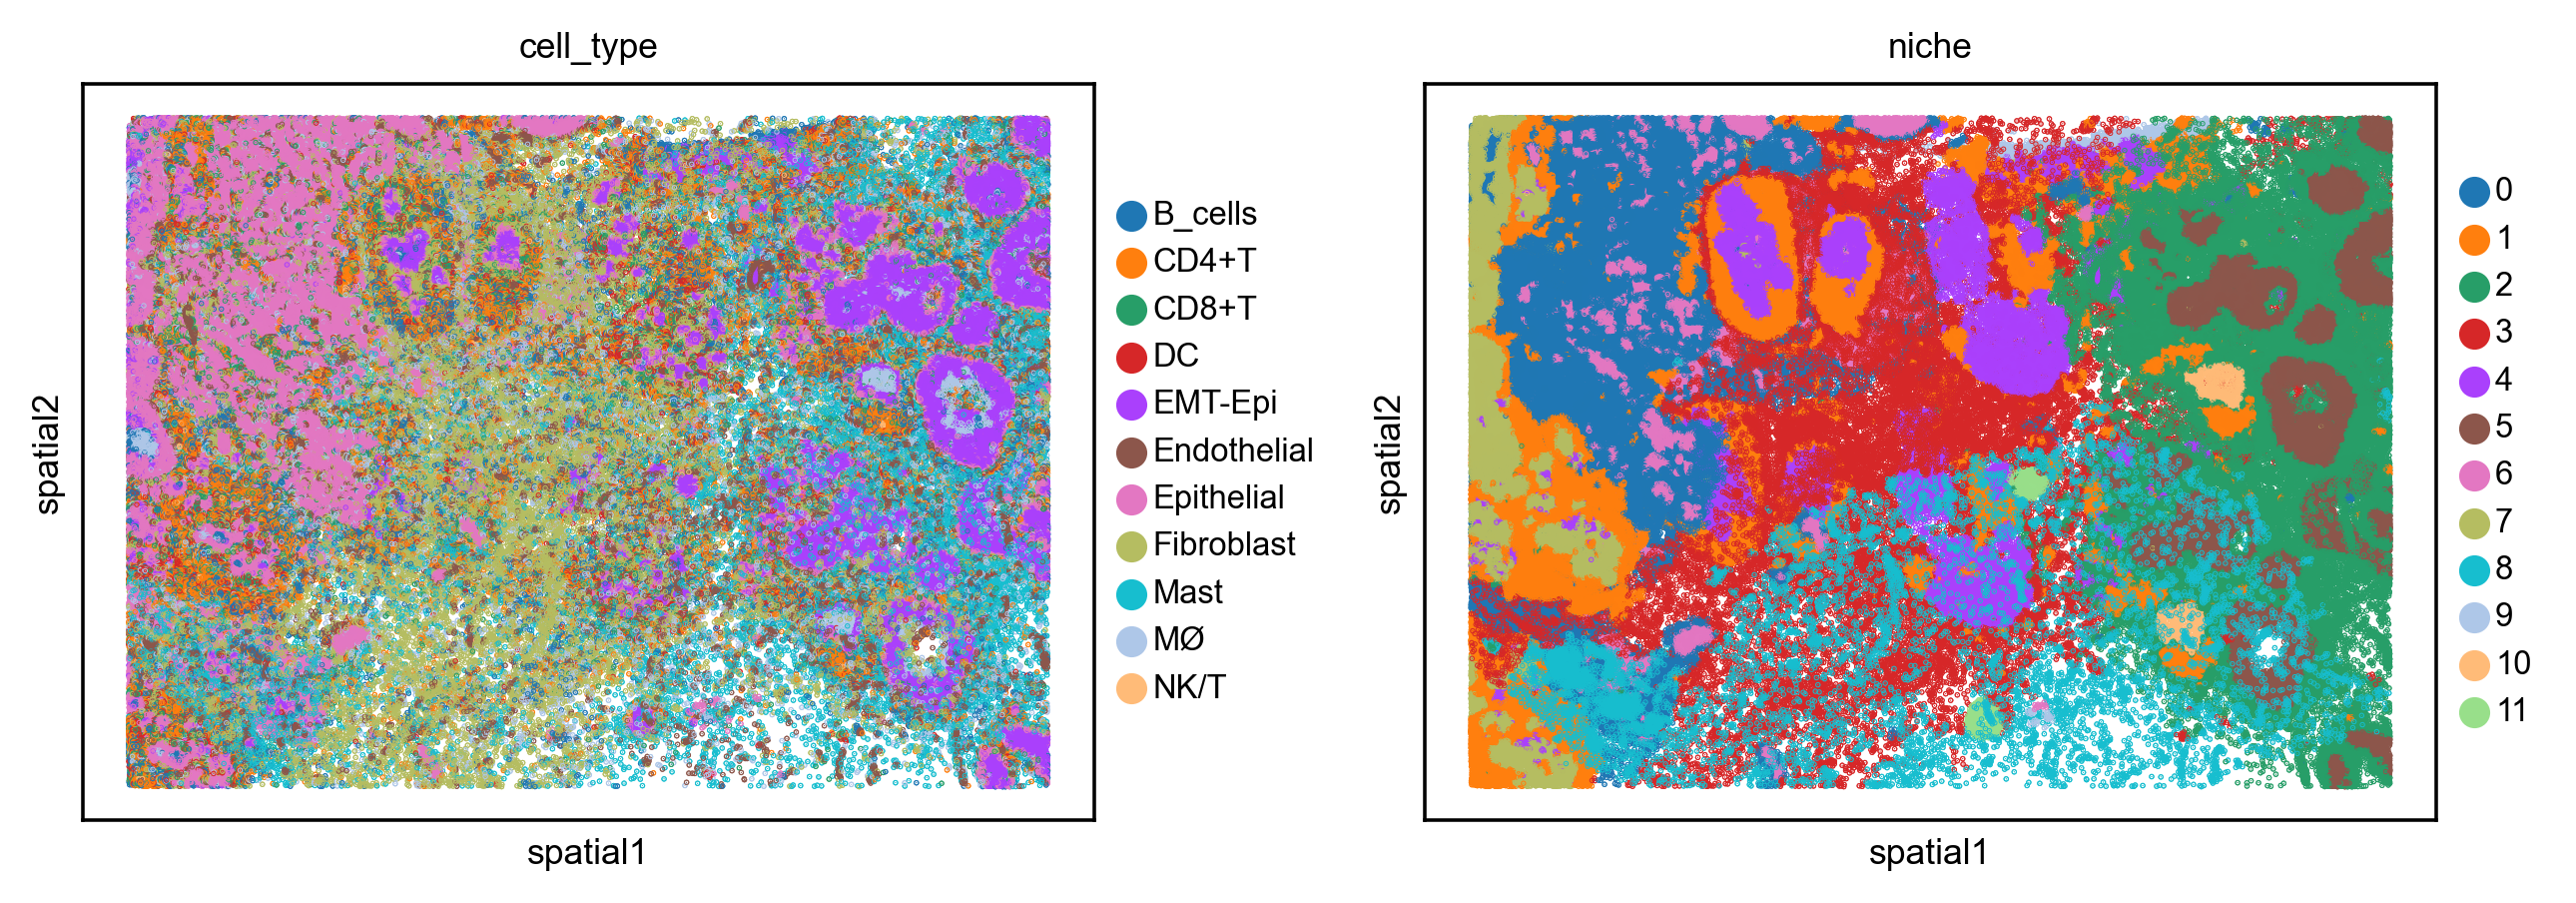

In [11]:
adata.obs['niche'] = adata.obs['latent_leiden_0.2'].copy()
adata.obs['niche'] = adata.obs['niche'].cat.rename_categories(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
sq.pl.spatial_scatter(adata, color = ["cell_type", "niche"], shape = None, size = 0.2)

### Read in GP summary output from `NicheCompass`

In [ ]:
GP_df = pd.read_csv('../../datasets/xenium/res_0.2_latent_clusters_all_vs_rest_log_bayes_factor_4.6_enriched_gps_summary.csv', sep = ',', index_col = 0)
GP_df = GP_df[GP_df['n_source_genes'] > 0]
GP_df.head()

In [ ]:
sq.pl.spatial_scatter(adata, color = ["cell_type", "niche", 'CD80_GP_score', 
                                      "FBLN2_GP_score",'UTS2_GP_score', 'SLAMF6_GP_score'], 
                                      shape = None, 
                                      size = 0.2, 
                                      ncols = 4, 
                                      cmap = 'PuOr_r', 
                                      frameon = False)

In [ ]:
sq.pl.spatial_scatter(adata, color = ["cell_type", "niche", 'CD80_GP_score',  
                                      'CTSD_GP_score', 'CD79B_GP_score', 'PLAT_GP_score'], 
                                      shape = None, 
                                      size = 0.2, 
                                      ncols = 4, 
                                      cmap = 'PuOr_r', 
                                      frameon = False)

In [ ]:
sq.pl.spatial_scatter(adata, color = ["cell_type", "niche", 'CD80_GP_score',
                                      'CD40LG_GP_score', 'ASIP_GP_score', 'TPSG1_GP_score'], 
                                      shape = None, 
                                      size = 0.2, 
                                      ncols = 4, 
                                      cmap = 'PuOr_r', 
                                      frameon = False)

In [ ]:
sq.pl.spatial_scatter(adata, color = ["cell_type", "niche", 'CD80_GP_score', 
                                      'SPINT1_GP_score', 'SEMA6D_GP_score', 'SEMA4G_GP_score'], 
                                      shape = None, 
                                      size = 0.2, 
                                      ncols = 4, 
                                      cmap = 'PuOr_r', 
                                      frameon = False)

In [ ]:
sq.pl.spatial_scatter(adata, color = ["cell_type", "niche", 'CD80_GP_score', 
                                      'KCNA1_GP_score', 'CD99_GP_score', 'HSPG2_GP_score'], 
                                      shape = None, 
                                      size = 0.2, 
                                      ncols = 4, 
                                      cmap = 'PuOr_r', 
                                      frameon = False)

In [ ]:
adata.write("../../datasets/xenium/xenium_human_breast_cancer_GP_scores_ctl230714.h5ad")

In [ ]:
sq.pl.spatial_scatter(adata, color = ["cell_type", "niche", 'CD80_GP_score', 
                                      'SLAMF6_GP_score', 'SEMA6D_GP_score', 'SEMA4G_GP_score',
                                      'PLAT_GP_score', 'ASIP_GP_score', 'TPSG1_GP_score'], 
                                      shape = None, 
                                      size = 0.2, 
                                      ncols = 3, 
                                      cmap = 'PuOr_r', 
                                      frameon = False)

In [ ]:
sq.pl.spatial_scatter(adata, color = ["cell_type", "niche", 'CD80_GP_score', 
                                      'SLAMF6_GP_score', 'SEMA6D_GP_score', 'SEMA4G_GP_score',
                                      'PLAT_GP_score', 'ASIP_GP_score', 'TPSG1_GP_score'], 
                                      shape = None, 
                                      size = 0.2, 
                                      ncols = 3, 
                                      cmap = 'PuOr_r', 
                                      frameon = False, 
                                      library_id = 'Rep_2')

### Investigate active GPs

In [ ]:
adata.uns['nichecompass_active_gp_names'].shape

### Create a plot for Niche composition

In [ ]:
adata

In [ ]:
adata.obs['cell_states'].cat.categories

In [ ]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type'].cat.categories

### Building the spatial neighbors graphs

In [ ]:
sq.gr.spatial_neighbors(adata, coord_type = "generic", delaunay = True)

- Compute centrality scores

In [ ]:
sq.gr.centrality_scores(adata, cluster_key = "latent_leiden_0.2")
sq.pl.centrality_scores(adata, cluster_key = "latent_leiden_0.2", figsize = (16, 5))

### Compute co-occurrence probability - celltype

In [ ]:
adata_subsample = sc.pp.subsample(adata, fraction = 0.5, copy = True)

In [ ]:
sq.gr.co_occurrence(
    adata_subsample,
    cluster_key = "cell_type",
)

In [ ]:
sq.pl.co_occurrence(
    adata_subsample,
    cluster_key = "cell_type",
    clusters = ["Fibroblast", 'MØ', 'CD4+T', 'EMT-Epi'],
    figsize = (15, 5),
)

In [ ]:
sq.pl.spatial_scatter(
    adata_subsample,
    color = "cell_type",
    shape = None,
    size = 0.4,
)

### Compute co-occurrence probability - niche

In [ ]:
sq.gr.co_occurrence(
    adata_subsample,
    cluster_key = "latent_leiden_0.2",
)

In [ ]:
sq.pl.co_occurrence(
    adata_subsample,
    cluster_key = "latent_leiden_0.2",
    clusters = ["0", '1', '2'],
    figsize = (15, 5),
)

In [ ]:
sq.pl.spatial_scatter(
    adata_subsample,
    color = "latent_leiden_0.2",
    shape = None,
    size = 0.1,
)

### Compute Moran's I score

In [ ]:
sq.gr.spatial_neighbors(adata_subsample, coord_type = "generic", delaunay = True)
sq.gr.spatial_autocorr(
    adata_subsample,
    mode = "moran",
    n_perms = 100,
    n_jobs = 4,
)
adata_subsample.uns["moranI"].head(10)

In [ ]:
sq.gr.nhood_enrichment(adata, cluster_key = "latent_leiden_0.2")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key = "latent_leiden_0.2",
    figsize = (8, 8),
    title = "Neighborhood enrichment adata",
    ax=ax[0],
    cmap = 'plasma')
sq.pl.spatial_scatter(adata_subsample, color = "latent_leiden_0.2", shape = None, size = 2, ax = ax[1])

### Proportions 

### Annotate niches in `adata.obs['latent_leiden_0.2']`

In [ ]:
adata.obs['latent_leiden_0.2'].cat.categories

In [ ]:
sq.pl.spatial_scatter(adata, color = ["cell_type", "niche"], shape = None, size = 0.2, library_key = 'replicates', ncols = 2)

In [ ]:
sq.gr.nhood_enrichment(adata, cluster_key = "niche")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key = "niche",
    figsize = (8, 8),
    title = "Neighborhood enrichment adata",
    ax=ax[0],
    cmap = 'plasma')
sq.pl.spatial_scatter(adata, color = "niche", shape = None, size = 2, ax = ax[1], library_id = 'Rep_2')

### Visualise programmes _in situ_